# GBM and XGBoost Gridsearch Demo

In this tutorial, we will go through a step-by-step workflow to demonstrate how easy it is to use H2OXGBoost with Gridsearch.

Begin by starting H2O

In [1]:
import h2o
h2o.init(bind_to_localhost=False)  # run and expose the cluster to the Internet

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.1" 2018-10-16 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.1+13-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.1+13-LTS, mixed mode)
  Starting server from /anaconda3/envs/h2o-3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/pk/4f3zrljs129_456_b6fvd0bm0000gp/T/tmp8t55fr51
  JVM stdout: /var/folders/pk/4f3zrljs129_456_b6fvd0bm0000gp/T/tmp8t55fr51/h2o_dwhiting_started_from_python.out
  JVM stderr: /var/folders/pk/4f3zrljs129_456_b6fvd0bm0000gp/T/tmp8t55fr51/h2o_dwhiting_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_dwhiting_8e4dyf
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Titanic Data Set

We will look at the famous Titanic passenger data set and try to predict who lived and who died....

In [2]:
filename = "http://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/titanic.csv"
titanic = h2o.import_file(path = filename)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
titanic.head()

pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1,1,Allen Miss. Elisabeth Walton,female,29,0,0,24160,211.338,B5,S,2,nan,St Louis MO
1,1,Allison Master. Hudson Trevor,male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,Montreal PQ / Chesterville ON
1,0,Allison Miss. Helen Loraine,female,2,1,2,113781,151.55,C22 C26,S,nan,nan,Montreal PQ / Chesterville ON
1,0,Allison Mr. Hudson Joshua Creighton,male,30,1,2,113781,151.55,C22 C26,S,nan,135,Montreal PQ / Chesterville ON
1,0,Allison Mrs. Hudson J C (Bessie Waldo Daniels),female,25,1,2,113781,151.55,C22 C26,S,nan,nan,Montreal PQ / Chesterville ON
1,1,Anderson Mr. Harry,male,48,0,0,19952,26.55,E12,S,3,nan,New York NY
1,1,Andrews Miss. Kornelia Theodosia,female,63,1,0,13502,77.9583,D7,S,10,nan,Hudson NY
1,0,Andrews Mr. Thomas Jr,male,39,0,0,112050,0,A36,S,nan,nan,Belfast NI
1,1,Appleton Mrs. Edward Dale (Charlotte Lamson),female,53,2,0,11769,51.4792,C101,S,nan,nan,Bayside Queens NY
1,0,Artagaveytia Mr. Ramon,male,71,0,0,nan,49.5042,,C,nan,22,Montevideo Uruguay


Set `survived` as a factor so that H2O can build a classification model. Also cast `ticket` as a factor rather than numeric.

In [4]:
titanic["survived"] = titanic["survived"].asfactor()
titanic["ticket"] = titanic["ticket"].asfactor()

Set the predictors and response variables. Note that we exclude `name` because it is a text variable. We also exclude `boat` and `body`, because those variables would not have been known at the time of setting sail. Including those is a classic example of *data leakage*.

In [5]:
# Set predictors and response variable
response = "survived"
exclude = ["name", "survived", "boat", "body"]
# not including boat or body due to data leakage

predictors = list(set(titanic.col_names) - set(exclude))
predictors

['cabin',
 'home.dest',
 'sex',
 'sibsp',
 'ticket',
 'embarked',
 'pclass',
 'parch',
 'age',
 'fare']

Now create training and test data sets. Rather than creating a validation data set, we will use k-fold cross-validation.

In [6]:
train, test = titanic.split_frame(seed = 1234, 
                                  ratios = [0.75], 
                                  destination_frames = ["train.hex", "test.hex"])

## Default GBM Model

Build a GBM model with default settings.

In [7]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

#We only provide the required parameters, everything else is default
gbm_model = H2OGradientBoostingEstimator(seed = 1234, nfolds = 5)
gbm_model.train(x = predictors
                , y = response
                , training_frame = train
                , validation_frame = test
                , model_id = "gbm_default.hex"
               )

## Show a detailed model summary
print(gbm_model)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_default.hex


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.009773378633695259
RMSE: 0.09886039972453711
LogLoss: 0.04511978704515411
Mean Per-Class Error: 0.01174682144831396
AUC: 0.9993835934963629
pr_auc: 0.9884868227886418
Gini: 0.9987671869927257
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4754478963351963: 


,0,1,Error,Rate
0,600.0,3.0,0.005,(3.0/603.0)
1,7.0,371.0,0.0185,(7.0/378.0)
Total,607.0,374.0,0.0102,(10.0/981.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4754479,0.9867021,184.0
max f2,0.1887346,0.9895013,199.0
max f0point5,0.7116417,0.9923664,177.0
max accuracy,0.4754479,0.9898063,184.0
max precision,0.9942805,1.0,0.0
max recall,0.0876755,1.0,224.0
max specificity,0.9942805,1.0,0.0
max absolute_mcc,0.4754479,0.9784744,184.0
max min_per_class_accuracy,0.3010539,0.9841270,191.0
max mean_per_class_accuracy,0.4754479,0.9882532,184.0


Gains/Lift Table: Avg response rate: 38.53 %, avg score: 38.54 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101937,0.9933808,2.5952381,2.5952381,1.0,0.9939335,1.0,0.9939335,0.0264550,0.0264550,159.5238095,159.5238095
,2,0.0203874,0.9930039,2.5952381,2.5952381,1.0,0.9931524,1.0,0.9935430,0.0264550,0.0529101,159.5238095,159.5238095
,3,0.0305810,0.9929083,2.5952381,2.5952381,1.0,0.9929225,1.0,0.9933361,0.0264550,0.0793651,159.5238095,159.5238095
,4,0.0417941,0.9926080,2.5952381,2.5952381,1.0,0.9927783,1.0,0.9931865,0.0291005,0.1084656,159.5238095,159.5238095
,5,0.0509684,0.9924516,2.5952381,2.5952381,1.0,0.9925194,1.0,0.9930664,0.0238095,0.1322751,159.5238095,159.5238095
,6,0.1009174,0.9914309,2.5952381,2.5952381,1.0,0.9920110,1.0,0.9925440,0.1296296,0.2619048,159.5238095,159.5238095
,7,0.1590214,0.9900729,2.5952381,2.5952381,1.0,0.9906610,1.0,0.9918560,0.1507937,0.4126984,159.5238095,159.5238095
,8,0.2008155,0.9884381,2.5952381,2.5952381,1.0,0.9893078,1.0,0.9913257,0.1084656,0.5211640,159.5238095,159.5238095
,9,0.3007136,0.9710984,2.5952381,2.5952381,1.0,0.9833732,1.0,0.9886838,0.2592593,0.7804233,159.5238095,159.5238095
,10,0.4006116,0.1887346,2.1715258,2.4895795,0.8367347,0.7604952,0.9592875,0.9317818,0.2169312,0.9973545,117.1525753,148.9579547




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.22243649652469855
RMSE: 0.47163173824998095
LogLoss: 1.0112611318736224
Mean Per-Class Error: 0.27486869329937924
AUC: 0.7223261180964506
pr_auc: 0.6907051483042259
Gini: 0.4446522361929013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09897278808843726: 


,0,1,Error,Rate
0,185.0,21.0,0.1019,(21.0/206.0)
1,55.0,67.0,0.4508,(55.0/122.0)
Total,240.0,88.0,0.2317,(76.0/328.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0989728,0.6380952,84.0
max f2,0.0057143,0.7583548,202.0
max f0point5,0.2181206,0.7345972,72.0
max accuracy,0.2181206,0.7774390,72.0
max precision,0.9936127,1.0,0.0
max recall,0.0049733,1.0,210.0
max specificity,0.9936127,1.0,0.0
max absolute_mcc,0.2181206,0.5122364,72.0
max min_per_class_accuracy,0.0094913,0.6147541,135.0
max mean_per_class_accuracy,0.1259619,0.7251313,79.0


Gains/Lift Table: Avg response rate: 37.20 %, avg score: 20.45 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0121951,0.9932051,2.6885246,2.6885246,1.0,0.9934185,1.0,0.9934185,0.0327869,0.0327869,168.8524590,168.8524590
,2,0.0213415,0.9929686,2.6885246,2.6885246,1.0,0.9930166,1.0,0.9932463,0.0245902,0.0573770,168.8524590,168.8524590
,3,0.0304878,0.9924836,2.6885246,2.6885246,1.0,0.9927807,1.0,0.9931066,0.0245902,0.0819672,168.8524590,168.8524590
,4,0.0426829,0.9917292,2.6885246,2.6885246,1.0,0.9922357,1.0,0.9928578,0.0327869,0.1147541,168.8524590,168.8524590
,5,0.0518293,0.9913623,2.6885246,2.6885246,1.0,0.9915112,1.0,0.9926201,0.0245902,0.1393443,168.8524590,168.8524590
,6,0.1006098,0.9690084,2.1844262,2.4441133,0.8125,0.9843482,0.9090909,0.9886095,0.1065574,0.2459016,118.4426230,144.4113264
,7,0.1524390,0.9073039,1.7396336,2.2045902,0.6470588,0.9559677,0.82,0.9775113,0.0901639,0.3360656,73.9633558,120.4590164
,8,0.2012195,0.4155578,2.3524590,2.2404372,0.875,0.6530644,0.8333333,0.8988575,0.1147541,0.4508197,135.2459016,124.0437158
,9,0.3018293,0.0689100,1.0591157,1.8466634,0.3939394,0.1633258,0.6868687,0.6536803,0.1065574,0.5573770,5.9115748,84.6663355
,10,0.3993902,0.0145059,0.0840164,1.4160931,0.03125,0.0299251,0.5267176,0.5013126,0.0081967,0.5655738,-91.5983607,41.6093105




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.2580024967596257
RMSE: 0.5079394617074221
LogLoss: 1.0885231308598087
Mean Per-Class Error: 0.3199083945352602
AUC: 0.7481595549588916
pr_auc: 0.6914199660459752
Gini: 0.4963191099177833
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.007413848673190728: 


,0,1,Error,Rate
0,281.0,322.0,0.534,(322.0/603.0)
1,40.0,338.0,0.1058,(40.0/378.0)
Total,321.0,660.0,0.369,(362.0/981.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0074138,0.6512524,364.0
max f2,0.0074138,0.7780847,364.0
max f0point5,0.3786108,0.6362153,139.0
max accuracy,0.3786108,0.7166157,139.0
max precision,0.9945951,1.0,0.0
max recall,0.0045710,1.0,397.0
max specificity,0.9945951,1.0,0.0
max absolute_mcc,0.3786108,0.3781742,139.0
max min_per_class_accuracy,0.0136116,0.6517413,326.0
max mean_per_class_accuracy,0.0074138,0.6800916,364.0


Gains/Lift Table: Avg response rate: 38.53 %, avg score: 21.99 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101937,0.9934332,2.5952381,2.5952381,1.0,0.9938792,1.0,0.9938792,0.0264550,0.0264550,159.5238095,159.5238095
,2,0.0203874,0.9929864,2.5952381,2.5952381,1.0,0.9931978,1.0,0.9935385,0.0264550,0.0529101,159.5238095,159.5238095
,3,0.0305810,0.9925831,2.5952381,2.5952381,1.0,0.9927834,1.0,0.9932868,0.0264550,0.0793651,159.5238095,159.5238095
,4,0.0407747,0.9920054,2.5952381,2.5952381,1.0,0.9922044,1.0,0.9930162,0.0264550,0.1058201,159.5238095,159.5238095
,5,0.0509684,0.9915443,2.5952381,2.5952381,1.0,0.9917516,1.0,0.9927633,0.0264550,0.1322751,159.5238095,159.5238095
,6,0.1009174,0.9839158,2.0655977,2.3330928,0.7959184,0.9885798,0.8989899,0.9906927,0.1031746,0.2354497,106.5597668,133.3092833
,7,0.1508665,0.9433734,1.2181730,1.9639640,0.4693878,0.9723548,0.7567568,0.9846214,0.0608466,0.2962963,21.8172983,96.3963964
,8,0.2008155,0.4427052,1.6948494,1.8970268,0.6530612,0.7176662,0.7309645,0.9182213,0.0846561,0.3809524,69.4849368,89.7026831
,9,0.3007136,0.1116644,1.1916910,1.6627119,0.4591837,0.2378134,0.6406780,0.6921875,0.1190476,0.5,19.1690962,66.2711864
,10,0.4006116,0.0343106,1.0063168,1.4990307,0.3877551,0.0647721,0.5776081,0.5357328,0.1005291,0.6005291,0.6316812,49.9030656



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6486784,0.0245097,0.6980198,0.6834171,0.6197917,0.6190476,0.6231156
auc,0.7507926,0.0145089,0.7798131,0.7517939,0.7632464,0.7194381,0.7396717
err,0.3513216,0.0245097,0.3019802,0.3165829,0.3802083,0.3809524,0.3768844
err_count,68.8,4.0099874,61.0,63.0,73.0,72.0,75.0
f0point5,0.5736036,0.0144026,0.5959032,0.5860114,0.5731524,0.5769231,0.5360282
f1,0.6603724,0.0150007,0.6772487,0.6631016,0.6755555,0.6666667,0.6192893
f2,0.7786036,0.0209027,0.7843137,0.7635468,0.8225108,0.7894737,0.7331731
lift_top_group,2.6024115,0.1203512,2.7671232,2.7260275,2.4303796,2.3625,2.7260275
logloss,1.0898011,0.0378791,1.0139158,1.0618577,1.1163439,1.173819,1.083069
max_per_class_error,0.5044848,0.0622732,0.4031008,0.4126984,0.6194690,0.5871559,0.5


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-08-08 07:12:33,3.725 sec,0.0,0.4866711,0.6666091,0.5,0.0,1.0,0.6146789,0.4835104,0.6603650,0.5,0.0,1.0,0.6280488
,2019-08-08 07:12:33,3.743 sec,1.0,0.4452003,0.5856743,0.9769144,0.1399191,2.5952381,0.0519878,0.4684901,0.6303419,0.6890618,0.4191008,2.1947140,0.2439024
,2019-08-08 07:12:33,3.758 sec,2.0,0.4088044,0.5204822,0.9800841,0.9591220,2.5952381,0.0509684,0.4577170,0.6094062,0.6853613,0.4167986,2.1947140,0.2439024
,2019-08-08 07:12:33,3.770 sec,3.0,0.3769643,0.4668860,0.9798253,0.9563624,2.5952381,0.0468909,0.4500004,0.5946391,0.6843268,0.6868224,2.6885246,0.2439024
,2019-08-08 07:12:33,3.782 sec,4.0,0.3490062,0.4219411,0.9807291,0.9578127,2.5952381,0.0417941,0.4450305,0.5851724,0.6947716,0.7105110,2.6885246,0.2408537
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-08-08 07:12:33,4.454 sec,46.0,0.1029007,0.0496866,0.9993529,0.9963799,2.5952381,0.0112130,0.4709499,0.9790889,0.7281354,0.6956745,2.6885246,0.2256098
,2019-08-08 07:12:33,4.469 sec,47.0,0.1021164,0.0487258,0.9993660,0.9963947,2.5952381,0.0112130,0.4711039,0.9857181,0.7178696,0.6909552,2.6885246,0.2256098
,2019-08-08 07:12:34,4.483 sec,48.0,0.1007096,0.0473496,0.9993748,0.9964086,2.5952381,0.0101937,0.4712681,0.9915726,0.7197597,0.6918029,2.6885246,0.2256098
,2019-08-08 07:12:34,4.497 sec,49.0,0.0998994,0.0461218,0.9993748,0.9964100,2.5952381,0.0112130,0.4713208,1.0041580,0.7260067,0.6943525,2.6885246,0.2317073



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ticket,657.8322144,1.0,0.5619777
home.dest,266.7745972,0.4055359,0.2279022
sex,132.5997620,0.2015708,0.1132783
cabin,92.0741882,0.1399661,0.0786578
age,14.0834808,0.0214089,0.0120313
fare,5.6508651,0.0085901,0.0048275
sibsp,0.8564049,0.0013019,0.0007316
parch,0.3314377,0.0005038,0.0002831
pclass,0.3073703,0.0004672,0.0002626
embarked,0.0559804,0.0000851,0.0000478


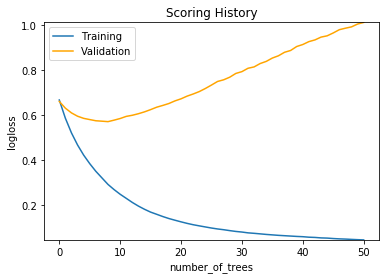

In [8]:
%matplotlib inline
gbm_model.plot()

Training Data


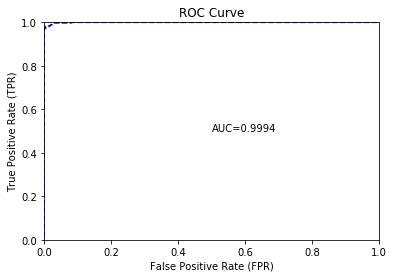

Cross-Validation


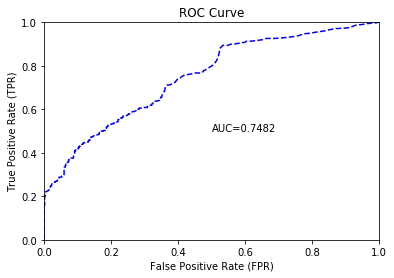

Testing Data


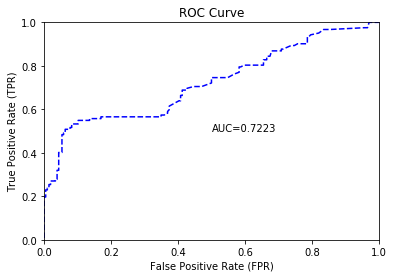

In [9]:
print("Training Data")
gbm_model.model_performance(train = True).plot()
print("Cross-Validation")
gbm_model.model_performance(xval = True).plot()
print("Testing Data")
gbm_model.model_performance(valid = True).plot()

The default GBM model overtrained pretty severely.

## Default XGBoost Models

Build an XGBoost default model

In [10]:
from h2o.estimators import H2OXGBoostEstimator

param = {"seed": 1234,
         "nfolds": 5
        }

xgboost_model = H2OXGBoostEstimator(**param)
xgboost_model.train(x = predictors
                    , y = response
                    , training_frame = train
                    , validation_frame = test
                    , model_id = "xgb_default.hex"
                   )

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [11]:
print(xgboost_model)

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  xgb_default.hex


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.048623020547565995
RMSE: 0.2205062823312887
LogLoss: 0.18249009143929026
Mean Per-Class Error: 0.056443970623075046
AUC: 0.9879943316925074
pr_auc: 0.9617454146200803
Gini: 0.9759886633850148
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41242945194244385: 


,0,1,Error,Rate
0,578.0,25.0,0.0415,(25.0/603.0)
1,27.0,351.0,0.0714,(27.0/378.0)
Total,605.0,376.0,0.053,(52.0/981.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4124295,0.9310345,185.0
max f2,0.2637685,0.9442170,224.0
max f0point5,0.5935437,0.9481743,151.0
max accuracy,0.4639233,0.9469929,171.0
max precision,0.9987952,1.0,0.0
max recall,0.1076461,1.0,297.0
max specificity,0.9987952,1.0,0.0
max absolute_mcc,0.4124295,0.8879969,185.0
max min_per_class_accuracy,0.3835851,0.9365079,193.0
max mean_per_class_accuracy,0.4124295,0.9435560,185.0


Gains/Lift Table: Avg response rate: 38.53 %, avg score: 38.59 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101937,0.9979911,2.5952381,2.5952381,1.0,0.9986664,1.0,0.9986664,0.0264550,0.0264550,159.5238095,159.5238095
,2,0.0203874,0.9971202,2.5952381,2.5952381,1.0,0.9976621,1.0,0.9981643,0.0264550,0.0529101,159.5238095,159.5238095
,3,0.0305810,0.9958567,2.5952381,2.5952381,1.0,0.9965299,1.0,0.9976195,0.0264550,0.0793651,159.5238095,159.5238095
,4,0.0417941,0.9938701,2.5952381,2.5952381,1.0,0.9947141,1.0,0.9968400,0.0291005,0.1084656,159.5238095,159.5238095
,5,0.0509684,0.9921354,2.5952381,2.5952381,1.0,0.9931033,1.0,0.9961674,0.0238095,0.1322751,159.5238095,159.5238095
,6,0.1009174,0.9776162,2.5952381,2.5952381,1.0,0.9848274,1.0,0.9905547,0.1296296,0.2619048,159.5238095,159.5238095
,7,0.1508665,0.9539461,2.5952381,2.5952381,1.0,0.9662497,1.0,0.9825078,0.1296296,0.3915344,159.5238095,159.5238095
,8,0.2008155,0.9081712,2.5952381,2.5952381,1.0,0.9316845,1.0,0.9698665,0.1296296,0.5211640,159.5238095,159.5238095
,9,0.3007136,0.7017462,2.5422741,2.5776433,0.9795918,0.8141273,0.9932203,0.9181294,0.2539683,0.7751323,154.2274052,157.7643261
,10,0.4006116,0.3462507,1.6154033,2.3376954,0.6224490,0.5233905,0.9007634,0.8196958,0.1613757,0.9365079,61.5403304,133.7695383




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1393124837799841
RMSE: 0.3732458757708973
LogLoss: 0.4453480681956972
Mean Per-Class Error: 0.19894954639503426
AUC: 0.8612326913894636
pr_auc: 0.8300558848854002
Gini: 0.7224653827789271
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32724255323410034: 


,0,1,Error,Rate
0,173.0,33.0,0.1602,(33.0/206.0)
1,29.0,93.0,0.2377,(29.0/122.0)
Total,202.0,126.0,0.189,(62.0/328.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3272426,0.7500000,122.0
max f2,0.0815927,0.8144476,211.0
max f0point5,0.7979221,0.8091787,72.0
max accuracy,0.7979221,0.8140244,72.0
max precision,0.9988791,1.0,0.0
max recall,0.0109745,1.0,287.0
max specificity,0.9988791,1.0,0.0
max absolute_mcc,0.7979221,0.6042693,72.0
max min_per_class_accuracy,0.2626761,0.7868852,134.0
max mean_per_class_accuracy,0.3272426,0.8010505,122.0


Gains/Lift Table: Avg response rate: 37.20 %, avg score: 35.78 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0121951,0.9973613,2.6885246,2.6885246,1.0,0.9983371,1.0,0.9983371,0.0327869,0.0327869,168.8524590,168.8524590
,2,0.0213415,0.9959690,2.6885246,2.6885246,1.0,0.9964666,1.0,0.9975355,0.0245902,0.0573770,168.8524590,168.8524590
,3,0.0304878,0.9922916,2.6885246,2.6885246,1.0,0.9944414,1.0,0.9966072,0.0245902,0.0819672,168.8524590,168.8524590
,4,0.0426829,0.9883919,2.6885246,2.6885246,1.0,0.9898224,1.0,0.9946687,0.0327869,0.1147541,168.8524590,168.8524590
,5,0.0518293,0.9863004,2.6885246,2.6885246,1.0,0.9877742,1.0,0.9934520,0.0245902,0.1393443,168.8524590,168.8524590
,6,0.1006098,0.9677027,2.6885246,2.6885246,1.0,0.9780392,1.0,0.9859792,0.1311475,0.2704918,168.8524590,168.8524590
,7,0.1524390,0.9023256,2.5303761,2.6347541,0.9411765,0.9323698,0.98,0.9677520,0.1311475,0.4016393,153.0376085,163.4754098
,8,0.2012195,0.8474604,2.0163934,2.4848485,0.75,0.8821094,0.9242424,0.9469902,0.0983607,0.5,101.6393443,148.4848485
,9,0.3018293,0.5372598,1.3849975,2.1182315,0.5151515,0.7029672,0.7878788,0.8656492,0.1393443,0.6393443,38.4997516,111.8231495
,10,0.3993902,0.2814761,1.3442623,1.9291703,0.5,0.4190258,0.7175573,0.7565503,0.1311475,0.7704918,34.4262295,92.9170317




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.15497725788207917
RMSE: 0.3936715101224359
LogLoss: 0.5025095200918688
Mean Per-Class Error: 0.22220247966516626
AUC: 0.8426540138812112
pr_auc: 0.7906731915995836
Gini: 0.6853080277624224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2807830373446147: 


,0,1,Error,Rate
0,455.0,148.0,0.2454,(148.0/603.0)
1,76.0,302.0,0.2011,(76.0/378.0)
Total,531.0,450.0,0.2283,(224.0/981.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2807830,0.7294686,233.0
max f2,0.1538423,0.7967836,284.0
max f0point5,0.7713924,0.7675112,101.0
max accuracy,0.4968631,0.7920489,169.0
max precision,0.9986352,1.0,0.0
max recall,0.0076254,1.0,394.0
max specificity,0.9986352,1.0,0.0
max absolute_mcc,0.4968631,0.5561919,169.0
max min_per_class_accuracy,0.3187344,0.7751323,221.0
max mean_per_class_accuracy,0.3455078,0.7777975,212.0


Gains/Lift Table: Avg response rate: 38.53 %, avg score: 38.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101937,0.9981536,2.5952381,2.5952381,1.0,0.9985283,1.0,0.9985283,0.0264550,0.0264550,159.5238095,159.5238095
,2,0.0203874,0.9971735,2.5952381,2.5952381,1.0,0.9977619,1.0,0.9981451,0.0264550,0.0529101,159.5238095,159.5238095
,3,0.0305810,0.9943609,2.5952381,2.5952381,1.0,0.9953593,1.0,0.9972165,0.0264550,0.0793651,159.5238095,159.5238095
,4,0.0407747,0.9926510,2.3357143,2.5303571,0.9,0.9935017,0.975,0.9962878,0.0238095,0.1031746,133.5714286,153.0357143
,5,0.0509684,0.9909267,2.5952381,2.5433333,1.0,0.9917253,0.98,0.9953753,0.0264550,0.1296296,159.5238095,154.3333333
,6,0.1009174,0.9740797,2.4363460,2.4903800,0.9387755,0.9835825,0.9595960,0.9895384,0.1216931,0.2513228,143.6345967,149.0379990
,7,0.1508665,0.9282224,2.1715258,2.3848134,0.8367347,0.9531978,0.9189189,0.9775067,0.1084656,0.3597884,117.1525753,138.4813385
,8,0.2008155,0.8542128,2.0655977,2.3054146,0.7959184,0.8965401,0.8883249,0.9573678,0.1031746,0.4629630,106.5597668,130.5414552
,9,0.3007136,0.6809213,1.5094752,2.0410008,0.5816327,0.7600453,0.7864407,0.8918166,0.1507937,0.6137566,50.9475219,104.1000807
,10,0.4006116,0.4084831,1.1387269,1.8160063,0.4387755,0.5246826,0.6997455,0.8002667,0.1137566,0.7275132,13.8726919,81.6006301



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.7847868,0.0238070,0.7871287,0.7939699,0.8385417,0.7354497,0.7688443
auc,0.8428826,0.0106457,0.8203250,0.8449119,0.8671446,0.8375,0.8445314
err,0.2152132,0.0238070,0.2128713,0.2060301,0.1614583,0.2645503,0.2311558
err_count,42.2,4.503332,43.0,41.0,31.0,50.0,46.0
f0point5,0.7105249,0.0338040,0.6982544,0.7074341,0.802005,0.6716418,0.6732892
f1,0.7476418,0.0210736,0.7225807,0.7421384,0.8050314,0.742268,0.7261905
f2,0.7909548,0.0191991,0.7486631,0.7804233,0.8080808,0.8294931,0.7881137
lift_top_group,2.6024115,0.1203512,2.7671232,2.7260275,2.4303796,2.3625,2.7260275
logloss,0.5021468,0.0223977,0.5263054,0.5211687,0.4402412,0.517144,0.5058746
max_per_class_error,0.2584396,0.0485111,0.2328767,0.2142857,0.1898734,0.3853211,0.2698413


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-08-08 07:12:44,4.463 sec,0.0,0.5,0.6931472,0.5,0.0,1.0,0.6146789,0.5,0.6931472,0.5,0.0,1.0,0.6280488
,2019-08-08 07:12:44,4.490 sec,1.0,0.4299369,0.5607069,0.8785701,0.5535257,2.5329524,0.1447503,0.4369712,0.5730345,0.8558611,0.5466357,2.6885246,0.1920732
,2019-08-08 07:12:44,4.509 sec,2.0,0.3904014,0.4890306,0.8879742,0.5597083,2.5329524,0.1416922,0.4013998,0.5070884,0.8453764,0.5458583,2.6885246,0.1707317
,2019-08-08 07:12:44,4.527 sec,3.0,0.3656590,0.4428930,0.9012894,0.6778163,2.5952381,0.1427115,0.3839576,0.4722383,0.8491565,0.6439597,2.6885246,0.1981707
,2019-08-08 07:12:44,4.555 sec,4.0,0.3497391,0.4116230,0.9053476,0.6827636,2.5952381,0.1355759,0.3715288,0.4458641,0.8637991,0.6518935,2.6885246,0.1890244
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-08-08 07:12:45,5.795 sec,46.0,0.2243710,0.1880803,0.9867769,0.9762213,2.5952381,0.0570846,0.3706509,0.4374316,0.8640976,0.8332929,2.6885246,0.1920732
,2019-08-08 07:12:45,5.822 sec,47.0,0.2234886,0.1869817,0.9871169,0.9765135,2.5952381,0.0560652,0.3714230,0.4389186,0.8637792,0.8327791,2.6885246,0.1920732
,2019-08-08 07:12:45,5.851 sec,48.0,0.2225408,0.1854002,0.9875424,0.9770785,2.5952381,0.0560652,0.3728392,0.4435897,0.8613521,0.8304340,2.6885246,0.1859756
,2019-08-08 07:12:45,5.878 sec,49.0,0.2221695,0.1849350,0.9876565,0.9772402,2.5952381,0.0560652,0.3723995,0.4427770,0.8619489,0.8308443,2.6885246,0.1890244



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
sex.female,597.4162598,1.0,0.3328096
fare,403.0107117,0.6745895,0.2245098
age,328.7783203,0.5503337,0.1831563
pclass,178.6654968,0.2990637,0.0995313
sibsp,71.7305603,0.1200680,0.0399598
home.dest.missing(NA),36.4743347,0.0610535,0.0203192
cabin.missing(NA),34.7800827,0.0582175,0.0193753
embarked.C,32.5289001,0.0544493,0.0181212
ticket.missing(NA),32.2556915,0.0539920,0.0179691
ticket.1601,27.1729927,0.0454842,0.0151376


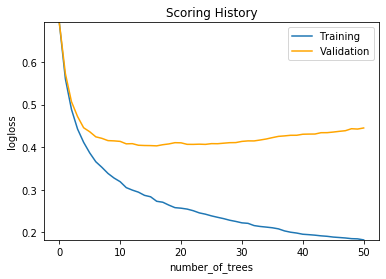

In [12]:
xgboost_model.plot()

Training Data


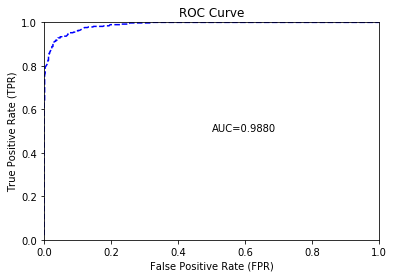

Cross-Validation


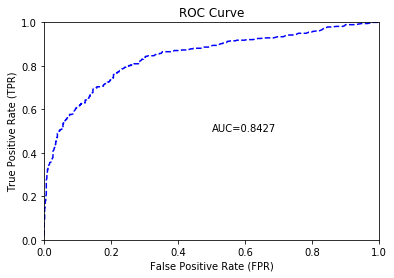

Testing Data


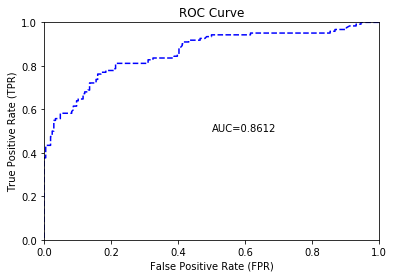

In [13]:
print("Training Data")
xgboost_model.model_performance(train = True).plot()
print("Cross-Validation")
xgboost_model.model_performance(xval = True).plot()
print("Testing Data")
xgboost_model.model_performance(valid = True).plot()

The default XGBoost model gives us a better result. Let's use gridsearch with early stopping on both models to see if we can improve their performance.

## GBM Gridsearch 

### Notes on parameter values

Our strategy is to start with a large number of trees and a small learning rate in combination with early stopping.

- Early stopping kicks in if the AUC doesn't improve by 0.001 for 5 consecutive scoring intervals. 
- We begin with a not-so-small 0.05 learning rate, but use `learn_rate_annealing` to decrease the learning rate by 1% after each tree. (Alternately, we could set annealing to 1 and make the learning rate smaller.)
- We sample 80% of rows per tree (`sample_rate`)
- We sample 80% of columns per split (`col_sample_rate`)

In [14]:
from h2o.grid.grid_search import H2OGridSearch

gbm_params = {'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
              , 'ntrees': [5000]
              , 'learn_rate': [0.05]
              , 'learn_rate_annealing': [0.99]
              , 'sample_rate': [0.8]
              , 'col_sample_rate': [0.8]
              , 'stopping_metric': 'AUC'
              , 'stopping_rounds': [5]
              , 'stopping_tolerance': [0.001]
             }

gbm_grid = H2OGridSearch(model = H2OGradientBoostingEstimator,
                         hyper_params = gbm_params
                        )

Early stopping is only reproducible if we use `score_tree_interval`; here we set it to score every 10 trees.

In [15]:
gbm_grid.train(x = predictors, y = response
               , training_frame = train
               , validation_frame = test
               , score_tree_interval = 10
               , seed = 1234
               , grid_id = "gbm_grid"
              )

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


## XGBoost Gridsearch

Let's do the same with XGBoost

In [16]:
xgboost_params = {'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
                  , 'ntrees': [5000]
                  , 'learn_rate': [1, 0.1, 0.01, 0.001]
                  , 'sample_rate': [0.8]
                  , 'col_sample_rate': [0.8]
                  , 'stopping_metric': 'AUC'
                  , 'stopping_rounds': [5]
                  , 'stopping_tolerance': [0.001]
                 }

xgboost_grid = H2OGridSearch(model = H2OXGBoostEstimator
                             , hyper_params = xgboost_params
                            )

In [17]:
xgboost_grid.train(x = predictors, y = response
                   , training_frame = train               
                   , validation_frame = test               
                   , score_tree_interval = 10              
                   , seed = 1234
                   , grid_id = "xgboost_grid"
              )

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


## Grid summary

### GBM Grid

In [18]:
## sort the grid models by decreasing AUC
sorted_gbm_grid = gbm_grid.get_grid(sort_by="auc", decreasing = True)
sorted_gbm_grid

     col_sample_rate learn_rate learn_rate_annealing max_depth ntrees  \
0                0.8       0.05                 0.99        15   5000   
1                0.8       0.05                 0.99        25   5000   
2                0.8       0.05                 0.99        19   5000   
3                0.8       0.05                 0.99        21   5000   
4                0.8       0.05                 0.99        23   5000   
5                0.8       0.05                 0.99        17   5000   
6                0.8       0.05                 0.99         9   5000   
7                0.8       0.05                 0.99        13   5000   
8                0.8       0.05                 0.99        11   5000   
9                0.8       0.05                 0.99         7   5000   
10               0.8       0.05                 0.99         5   5000   
11               0.8       0.05                 0.99         1   5000   
12               0.8       0.05                 0.9

In [19]:
best_gbm = sorted_gbm_grid.models[0]
best_gbm_perf = best_gbm.model_performance(test)
best_gbm_perf.auc()

0.7922966735635844

### XGBoost Grid

In [ ]:
## sort the grid models by decreasing AUC
sorted_xgboost_grid = xgboost_grid.get_grid(sort_by="auc", decreasing = True)
sorted_xgboost_grid

In [ ]:
best_xgboost = sorted_xgboost_grid.models[0]
best_xgboost_perf = best_xgboost.model_performance(test)
best_xgboost_perf.auc()

Even with gridsearch, XGBoost does a better job than GBM.